# Bikeshare Report

In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
df = pd.read_csv("hourly.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
df.shape

(17379, 17)

In [4]:
df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

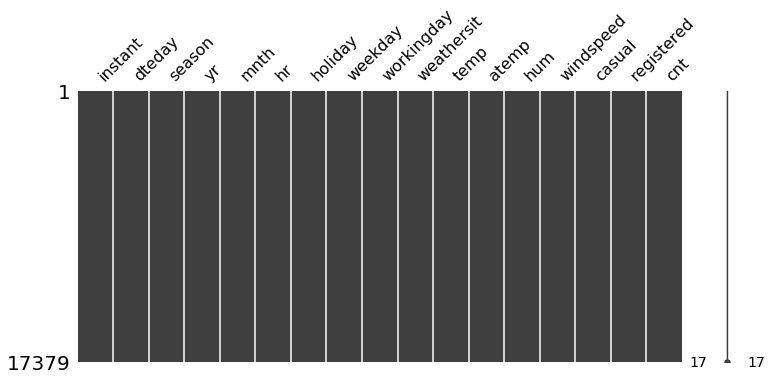

In [5]:
# Skewness In Distribution
msno.matrix(df,figsize=(12,5))

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

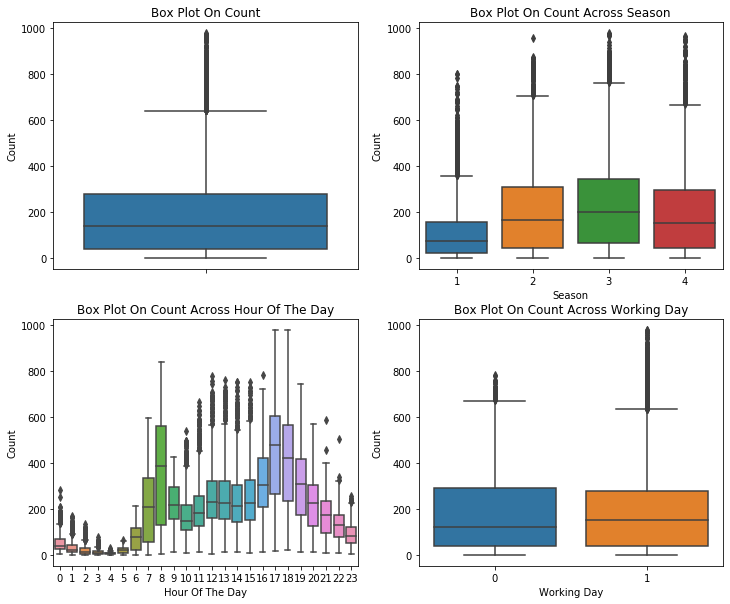

In [6]:
#Outliers Analysis
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=df,y="cnt",orient="v",ax=axes[0][0])
sn.boxplot(data=df,y="cnt",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=df,y="cnt",x="hr",orient="v",ax=axes[1][0])
sn.boxplot(data=df,y="cnt",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

In [7]:
# Lets Remove Outliers In The Count Column
dailyDataWithoutOutliers = df[np.abs(df["cnt"]-df["cnt"].mean())<=(3*df["cnt"].std())]

In [8]:
print ("Shape Of The Before Ouliers: ",df.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (17379, 17)
Shape Of The After Ouliers:  (17135, 17)


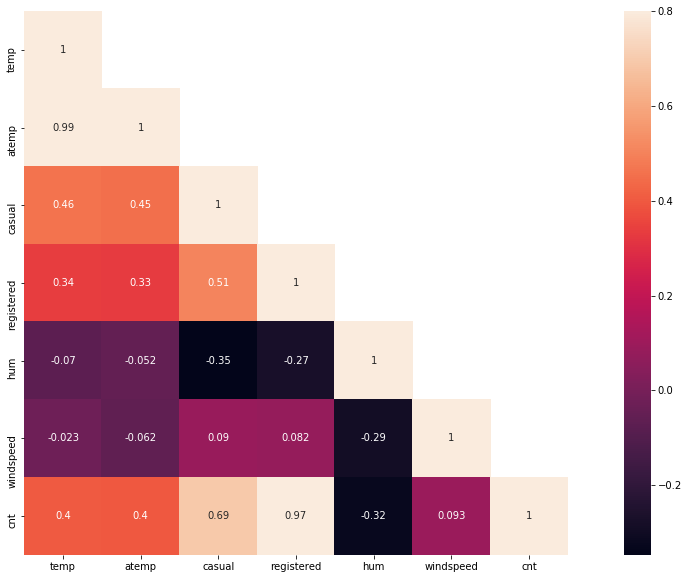

In [9]:
# Correlation Analysis
# plot a correlation plot between "count" and ["temp","atemp","hum","windspeed"]
corrMatt = df[["temp","atemp","casual","registered","hum","windspeed","cnt"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

- temp and hum features has got positive and negative correlation with "cnt" respectively.Although the correlation between them are not very prominent still the count variable has got little dependency on "temp" and "hum".

- windspeed is not gonna be really useful numerical feature and it is visible from it correlation value with "cnt"

- "atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.

- "Casual" and "Registered" are also not taken into account since they are leakage variables in nature and need to dropped during model building.

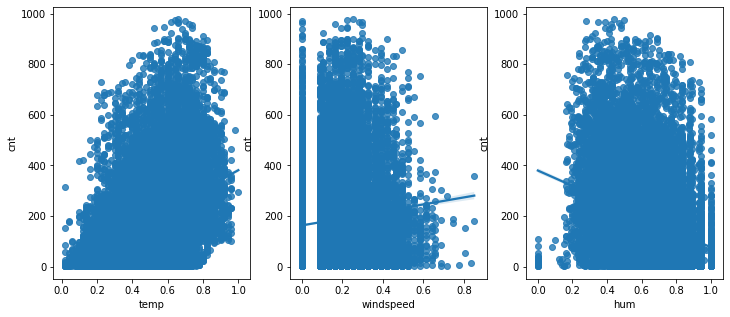

In [10]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="cnt", data=df,ax=ax1)
sn.regplot(x="windspeed", y="cnt", data=df,ax=ax2)
sn.regplot(x="hum", y="cnt", data=df,ax=ax3)

((array([-3.94171042, -3.72363151, -3.60421718, ...,  3.60421718,
          3.72363151,  3.94171042]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.5971457 ,
         6.59850903])),
 (1.3490324630370498, 4.544366339498316, 0.9601811537292402))

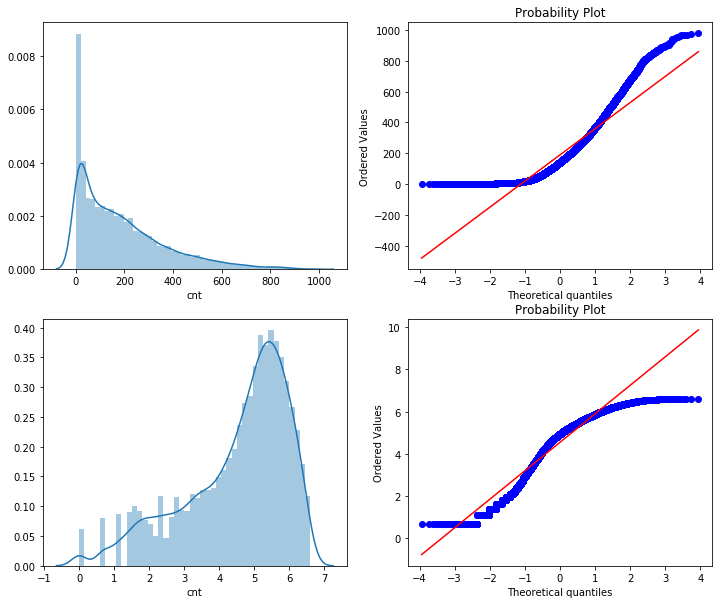

In [11]:
#Visualizing Distribution Of Data
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(df["cnt"],ax=axes[0][0])
stats.probplot(df["cnt"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["cnt"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["cnt"]), dist='norm', fit=True, plot=axes[1][1])

### Filling 0's In windspeed Using Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor

dfWind0 = df[df["windspeed"]==0]
dfWindNot0 = df[df["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weathersit","hum","mnth","temp","yr","atemp"]
rfModel_wind.fit(dfWindNot0[windColumns], dfWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dfWind0[windColumns])
dfWind0["windspeed"] = wind0Values
df = dfWindNot0.append(dfWind0)
df.reset_index(inplace=True)
df.drop('index',inplace=True,axis=1)

In [13]:
categoricalFeature = ["season","holiday","workingday","weathersit","weekday","mnth","yr","hr"]
numericalFeature = ["temp","hum","windspeed","atemp"]
dropFeatures = ['casual',"cnt","dteday","registered"]

In [14]:
for var in categoricalFeature:
    df[var] = df[var].astype("category")

In [15]:
# Splitting Train And Test Data
dataTrain = df[pd.notnull(df['cnt'])].sort_values(by=["dteday"])
dataTest = df[~pd.notnull(df['cnt'])].sort_values(by=["dteday"])
dtedaycol = dataTest["dteday"]
yLabels = dataTrain["cnt"]
yLablesRegistered = dataTrain["registered"]
yLablesCasual = dataTrain["casual"]

In [16]:
# Dropping Unncessary Variables
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)

In [17]:
#RMSLE Scorer
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

### Linear Regression Model

In [18]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels)
lModel.fit(X = dataTrain,y = yLabelsLog)

# Make predictions
preds = lModel.predict(X= dataTrain)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Linear Regression:  0.9791415325152443


### Gradiant Boost

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(X= dataTrain)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Gradient Boost:  0.16039468587089015


### Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Random Forest:  0.10539484873127078
